# Setting up, prerequisites

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib import colors
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import keras_tuner
import keras
import pandas as pd
from tensorflow.keras import layers
from keras import metrics
from sklearn import preprocessing
import math  
import datetime
import tensorflow_decision_forests as tfdf
import os
from keras.utils import plot_model
import tensorflow_datasets as tfds
from keras.utils import plot_model
import pydot
# import graphviz

global w 
global h 

2023-11-25 08:39:30.905391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-25 08:39:30.905477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-25 08:39:30.905558: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-25 08:39:30.920414: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CHECK TENSOR USING GPU
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-11-25 07:24:23.807557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 07:24:23.857889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 07:24:23.858454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

True

# Get data

In [ ]:
# SEPERATE SUBJECTS TO DIFFERENT DATASET

dataDir = "/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
dataFiles_train = ['female_1.mat','male_1.mat','male_2.mat']
dataFiles_test = ['female_2.mat','female_3.mat']
# dataFiles=['female_1.mat']

e = 2.718281828459045

def normalize_arr(arr,i):
    signal = arr.copy()
    signal = signal.tolist()
    signal.append(int(i/2))
    signal = np.array(signal)
    return signal

def get_channel_pair(chn1,chn2,i):
    paired_data = []
    label = int(i/2)
    chn1 =  list(np.delete(chn1,0,1))
    chn2 =  list(np.delete(chn2,0,1))

    for chunk1 in chn1:
        chunk2 = chn2[i].T
        chunk1 = chunk1.T

        while(len(chunk1)>0):
            row=[chunk1[0],chunk2[0],label]
            paired_data.append(row)

            chunk1 = list(chunk1)
            chunk2 = list(chunk2)
            chunk1.pop(0)
            chunk2.pop(0)

    return paired_data


def getData(dataFiles):
    data = [] #processed and normalised with pose_idx
    for file in dataFiles:
        data_path = dataDir+file
        print(data_path)
        mat = scipy.io.loadmat(data_path)
        mat.pop("__header__")
        mat.pop("__version__")
        mat.pop("__globals__")
        i=0

        plot_interval = 100
        plot_index = 0

        for channel in mat: 
        
            if(i%2==0):
                channel2 =  channel[:-1]
                channel2 += '2'
                sigs1 = mat[channel] 
                sigs2 = mat[channel2]
                sigs1_norm = []
                sigs2_norm = []

                for signal in sigs1:
                    # signal = normalize_arr(signal,i)
                    if(signal[0]<2):
                        sigs1_norm.append(signal)
                        sigs2_norm.append(signal)
                # for signal in sigs2:
                #     # signal = normalize_arr(signal,i)
                #     if(signal[0]<2):
                #         sigs2_norm.append(signal)

                if i==0:
                    data = get_channel_pair(sigs1_norm,sigs2_norm,i)
                else:
                    None
                    data_lc = get_channel_pair(sigs1_norm,sigs2_norm,i)
                    data += data_lc
            i+=1
    return data
def get_nm_data(dataFiles):
    data = getData(dataFiles)
    print(np.array(data).shape)
    print(data[-3])




    data_nm = np.copy(data)[:,:2]
    data_nm.shape
    nm_c1 =  preprocessing.normalize([data_nm.T[0]]).T.flatten()
    nm_c2 =  preprocessing.normalize([data_nm.T[1]]).T.flatten()
    df_data_nm = pd.DataFrame(np.vstack((nm_c1,nm_c2)).T, columns = ['channel1','channel2'])

    label_arr=[]

    for row in data:
        label_arr.append(int(row[2]))
    print(label_arr)

    data_nm = df_data_nm.assign(label=label_arr)
    return data_nm
data_train_nm = get_nm_data(dataFiles_train)
data_test_nm = get_nm_data(dataFiles_test)

#==========================================

def GetSpacedElements(array, numElems = 4):
    out = array[np.round(np.linspace(0, len(array)-1, numElems)).astype(int)]
    return out

sample = 200
rate = sample * 6
print(rate)

test_d = np.copy(data_train_nm)
test_c = np.copy(data_test_nm)

if True:
    test_d=  GetSpacedElements(test_d,rate)
    test_c=  GetSpacedElements(test_c,rate)
test_d = test_d.T
test_c = test_c.T

b = np.array((np.hsplit(test_d, 6)))
a = np.array((np.hsplit(test_c, 6)))


print(test_d.shape)
print(b.shape)
#////////////////////============
def display_signals(b):
    w = 20
    h = 20
    fig = plt.figure(figsize=(10, 10))
    columns = 1
    rows = 2

    for index in range(1,2+1):
        idx = 0
        fig.add_subplot(rows, columns, index)
        for signal in b:
            plt.plot(signal[index-1],label=str(idx))
            idx += 1
        plt.title('channel '+str(index))
        plt.legend(ncol=1)
        
            
    plt.show()
    fig = plt.figure(figsize=(20, 20))
    columns = 2
    rows = 3
    idx = 0

    for signal in b:
        fig.add_subplot(rows, columns, idx+1)
        plt.plot(signal[0],color='blue',label=str(0))
        plt.plot(signal[1],color='orange',label=str(1))
        idx += 1
        plt.title('pose '+str(idx-1))
        plt.legend(ncol=1)
            
    plt.show()
display_signals(b)
display_signals(a)

def reshape_data(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        tmp = reshape_data.tolist()
        tmp.append(int(label[i]))
        tmp = np.array(tmp)

        if(len(reshape_data)==n*2):
            newShape_data.append(tmp)
        i += n

    newShape_data = np.array(newShape_data)
    return newShape_data

def split_X(arr):
    arr = arr.T
    arr = arr[0:-1]
    arr = arr.T
    return arr
def split_y(arr):
    arr = arr.T
    arr = arr[-1]
    arr = arr.T.astype(np.uint8)
    return arr
def reshape_arr(arr):
    new_shape = []
    for row in arr:
        n_len =int(math.sqrt(len(row)))
        row = row.reshape(n_len,n_len)
        new_shape.append(row)
    return np.array(new_shape)
def reshape_arr_img_transfer(arr,n):
    new_shape = []
    for row in arr:
        n_len = len(row)
        # row =np.pad(row,(0,n-n_len),'symmetric')
        row =np.pad(row,(0,n-n_len),'constant',constant_values=10)
        row = row.reshape(n,n)
        new_shape.append(row)
    return np.array(new_shape)
def signal_to_3channelimg(arr):
    print(arr[0].shape)
    rgb_batch_ts =  np.repeat(arr[..., np.newaxis], 3, -1)
    rgb_batch_ts.shape
    return rgb_batch_ts
# print(df)
def reshape_for_conv2d(t,w,h):
    train_size = int(len(t) * len(t[0])* len(t[0][0]) / (w*h))
    reshaped_tuple = t.reshape(train_size, w,h, 1)
    return reshaped_tuple




dataset_train = data_train_nm
dataset_test = data_test_nm

val_test_mask = np.random.rand(len(data_train_nm)) < 0.5

dataset_train = data_train_nm[val_test_mask]
dataset_val = data_train_nm[~val_test_mask]

img_w_h_len = 40
n = int(img_w_h_len * img_w_h_len / 2)

dataset_train_ar = reshape_data(n,dataset_train)
dataset_test_ar = reshape_data(n,dataset_test)
dataset_val_ar = reshape_data(n,dataset_val)

# print(dataset_train_ar[-20:][-1])

np.random.shuffle(dataset_train_ar)
np.random.shuffle(dataset_test_ar)
np.random.shuffle(dataset_val_ar)

# print(dataset_train_ar[-20:][-1])

X = split_X(dataset_train_ar)
y = split_y(dataset_train_ar)
print("X shape:",X.shape)

X_val = split_X(dataset_val_ar)
y_val = split_y(dataset_val_ar)

X_test = split_X(dataset_test_ar)
y_test = split_y(dataset_test_ar)


# OPTIONAL TURN X TO NxN
X = reshape_arr(X)
X_test = reshape_arr(X_test)
X_val = reshape_arr(X_val)



w = img_w_h_len
h = img_w_h_len
X = reshape_for_conv2d(X,w,h)
X_test = reshape_for_conv2d(X_test,w,h)
X_val = reshape_for_conv2d(X_val,w,h)
X_test = reshape_for_conv2d(X_test,w,h)




## Get Data as if it's true data


In [45]:
# SEPERATE SUBJECTS TO DIFFERENT DATASET - NO SHUFFLE

dataDir = "/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
dataFiles_train = ['female_1.mat','male_1.mat','male_2.mat']
dataFiles_test = ['female_2.mat','female_3.mat']
# dataFiles=['female_1.mat']

e = 2.718281828459045





dataset_train = data_train_nm
dataset_test = data_test_nm

val_test_mask = np.random.rand(len(data_train_nm)) < 0.5

dataset_train = data_train_nm[val_test_mask]
dataset_val = data_train_nm[~val_test_mask]

img_w_h_len = 40
n = int(img_w_h_len * img_w_h_len / 2)

dataset_train_ar = reshape_data(n,dataset_train)
dataset_test_ar = reshape_data(n,dataset_test)
dataset_val_ar = reshape_data(n,dataset_val)



# print(dataset_train_ar[-20:][-1])

X = split_X(dataset_train_ar)
y = split_y(dataset_train_ar)
print("X shape:",X.shape)

X_val = split_X(dataset_val_ar)
y_val = split_y(dataset_val_ar)

X_test = split_X(dataset_test_ar)
y_test = split_y(dataset_test_ar)


# OPTIONAL TURN X TO NxN
X = reshape_arr(X)
X_test = reshape_arr(X_test)
X_val = reshape_arr(X_val)



w = img_w_h_len
h = img_w_h_len
X = reshape_for_conv2d(X,w,h)
X_test = reshape_for_conv2d(X_test,w,h)
X_val = reshape_for_conv2d(X_val,w,h)
X_test = reshape_for_conv2d(X_test,w,h)




X shape: (337, 1600)


In [ ]:
# ALT WAY TO GET TEST AND TRAIN DATA: MERGE & NO SHUFFLE


dataDir = "/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
dataFiles=['female_1.mat','male_1.mat','male_2.mat']
dataFiles=['female_2.mat','female_3.mat']
# dataFiles=['female_1.mat']

data = [] #processed and normalised with pose_idx
e = 2.718281828459045

def normalize_arr(arr,i):
    signal = arr.copy()
    # signal = e**signal
    # signal /= np.sum(signal)
    # signal = np.clip(signal,1e-7,1e+7)
    signal = signal.tolist()
    signal.append(int(i/2))
    signal = np.array(signal)
    return signal

def get_channel_pair(chn1,chn2,i):
    paired_data = []
    # label = list((np.array(chn1).T)[-1].T.astype(int))
    label = int(i/2)
    chn1 =  list(np.delete(chn1,0,1))
    chn2 =  list(np.delete(chn2,0,1))
    # print(np.array(chn1).shape)
    # print(label)
    # print('label[i]: ',label[i])
    for chunk1 in chn1:
        chunk2 = chn2[i].T
        chunk1 = chunk1.T

        while(len(chunk1)>0):
            row=[chunk1[0],chunk2[0],label]
            paired_data.append(row)

            chunk1 = list(chunk1)
            chunk2 = list(chunk2)
            chunk1.pop(0)
            chunk2.pop(0)

    return paired_data



for file in dataFiles:
    data_path = dataDir+file
    print(data_path)
    mat = scipy.io.loadmat(data_path)
    mat.pop("__header__")
    mat.pop("__version__")
    mat.pop("__globals__")
    i=0

    plot_interval = 100
    plot_index = 0

    for channel in mat: 
       
        if(i%2==0):
            channel2 =  channel[:-1]
            channel2 += '2'
            sigs1 = mat[channel] 
            sigs2 = mat[channel2]
            sigs1_norm = []
            sigs2_norm = []

            for signal in sigs1:
                # signal = normalize_arr(signal,i)
                if(signal[0]<2):
                    sigs1_norm.append(signal)
            for signal in sigs2:
                # signal = normalize_arr(signal,i)
                if(signal[0]<2):
                    sigs2_norm.append(signal)
            if i==0:
                data = get_channel_pair(sigs1_norm,sigs2_norm,i)
            else:
                None
                data_lc = get_channel_pair(sigs1_norm,sigs2_norm,i)
                data += data_lc
        i+=1

print(np.array(data).shape)
print(data[-3])



from sklearn import preprocessing

data_nm = np.copy(data)[:,:2]
data_nm.shape
nm_c1 =  preprocessing.normalize([data_nm.T[0]]).T.flatten()
nm_c2 =  preprocessing.normalize([data_nm.T[1]]).T.flatten()
# nm_c2 = data_nm.T[1].T
df_data_nm = pd.DataFrame(np.vstack((nm_c1,nm_c2)).T, columns = ['channel1','channel2'])

label_arr=[]

for row in data:
    label_arr.append(int(row[2]))
print(label_arr)

data_nm = df_data_nm.assign(label=label_arr)
data_nm

#==========================================

def GetSpacedElements(array, numElems = 4):
    out = array[np.round(np.linspace(0, len(array)-1, numElems)).astype(int)]
    return out

sample = 200
rate = sample * 6
print(rate)

# test_d = np.copy(data)
test_d = np.copy(data_nm)

if True:
    test_d=  GetSpacedElements(test_d,rate)
test_d = test_d.T

# test_d = list(test_d)
b = np.array((np.hsplit(test_d, 6)))
# b = test_d


print(test_d.shape)
print(b.shape)
#////////////////////============

w = 20
h = 20
fig = plt.figure(figsize=(10, 10))
columns = 1
rows = 2

for index in range(1,2+1):
    idx = 0
    fig.add_subplot(rows, columns, index)
    for signal in b:
        plt.plot(signal[index-1],label=str(idx))
        idx += 1
    plt.title('channel '+str(index))
    plt.legend(ncol=1)
    
        
plt.show()
w = 20
h = 20
fig = plt.figure(figsize=(20, 20))
columns = 2
rows = 3
idx = 0

for signal in b:
    fig.add_subplot(rows, columns, idx+1)
    plt.plot(signal[0],color='blue',label=str(0))
    plt.plot(signal[1],color='orange',label=str(1))
    # plt.plot(signal[0],'r-d',label=str(0))
    # plt.plot(signal[1],'k-o',label=str(1))
    idx += 1
    plt.title('pose '+str(idx-1))
    plt.legend(ncol=1)
        
plt.show()
import pandas as pd
import math  
def reshape_data(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        tmp = reshape_data.tolist()
        tmp.append(int(label[i]))
        tmp = np.array(tmp)

        if(len(reshape_data)==n*2):
            newShape_data.append(tmp)
        i += n

    newShape_data = np.array(newShape_data)
    return newShape_data

def split_X(arr):
    arr = arr.T
    arr = arr[0:-1]
    arr = arr.T
    return arr
def split_y(arr):
    arr = arr.T
    arr = arr[-1]
    arr = arr.T.astype(np.uint8)
    return arr
def reshape_arr(arr):
    new_shape = []
    for row in arr:
        n_len =int(math.sqrt(len(row)))
        row = row.reshape(n_len,n_len)
        new_shape.append(row)
    return np.array(new_shape)
def reshape_arr_img_transfer(arr,n):
    new_shape = []
    for row in arr:
        n_len = len(row)
        # row =np.pad(row,(0,n-n_len),'symmetric')
        row =np.pad(row,(0,n-n_len),'constant',constant_values=10)
        row = row.reshape(n,n)
        new_shape.append(row)
    return np.array(new_shape)
def signal_to_3channelimg(arr):
    print(arr[0].shape)
    rgb_batch_ts =  np.repeat(arr[..., np.newaxis], 3, -1)
    rgb_batch_ts.shape
    return rgb_batch_ts
# print(df)
def reshape_for_conv2d(t,w,h):
    train_size = int(len(t) * len(t[0])* len(t[0][0]) / (w*h))
    reshaped_tuple = t.reshape(train_size, w,h, 1)
    return reshaped_tuple

df = data_nm
# df = pd.DataFrame(data.copy(),columns = ['channel1','channel2','label'])


mask = np.random.rand(len(df)) < 0.8
dataset_t_v = df[mask] #test & val
dataset_test = df[~mask]

val_test_mask = np.random.rand(len(dataset_t_v)) < 0.5
dataset_train = dataset_t_v[val_test_mask]
dataset_val = dataset_t_v[~val_test_mask]
img_w_h_len = 40
n = int(img_w_h_len * img_w_h_len / 2)

dataset_train_ar = reshape_data(n,dataset_train)
dataset_test_ar = reshape_data(n,dataset_test)
dataset_val_ar = reshape_data(n,dataset_val)
# print(dataset_train_ar[-20:][-1])


# print(dataset_train_ar[-20:][-1])

X = split_X(dataset_train_ar)
y = split_y(dataset_train_ar)
print("X shape:",X.shape)

X_val = split_X(dataset_train_ar)
y_val = split_y(dataset_train_ar)

X_test = split_X(dataset_test_ar)
y_test = split_y(dataset_test_ar)


# OPTIONAL TURN X TO NxN
X = reshape_arr(X)
X_val = reshape_arr(X_val)
X_test = reshape_arr(X_test)

# OPTIONAL TURN X TO NxN | N>= 150 transfer learning
tuple_size = 150
X_tl = reshape_arr_img_transfer(X,tuple_size)
# X_val_tl = reshape_arr_img_transfer(X_val,tuple_size)
# X_test_tl = reshape_arr_img_transfer(X_test,tuple_size)
w = img_w_h_len
h = img_w_h_len
X_test = reshape_for_conv2d(X_test,w,h)
X = reshape_for_conv2d(X,w,h)

# X_tl = signal_to_3channelimg(X_tl)
# X = signal_to_3channelimg(X)
# X_test = signal_to_3channelimg(X_test)


# Display the signal image

In [ ]:
w = 20
h = 20
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title(y[i-1])
    plt.imshow(X_test[i-1],cmap='gnuplot2')
    # plt.imshow(X[i-1]*255)
plt.show()
print(y[:(columns*rows)])

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title(y[i-1])
    # plt.imshow(X[i-1]*255,cmap='gnuplot2')
    plt.imshow(X[i-1],cmap='gnuplot2')
    # plt.imshow(X[i-1]*255)

plt.show()
print(y_test[:(columns*rows)])



w = img_w_h_len
h = img_w_h_len

# NN
## training & evaluate

In [36]:
# MODEL - CONV2D + DENSE
w = 40
h = 40
input_shape = [w, h, 1]

inputs = keras.Input(shape=input_shape)
x = layers.Rescaling(scale=2)(inputs)

x = layers.Conv2D(64, (3,3), activation='relu',use_bias=True, input_shape=input_shape[1:])(x)
x = layers.MaxPooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(x)

x = keras.layers.Dropout(0.5)(x,training=True)   # Regularize with dropout

x = layers.Conv2D(32, (5,5), activation='relu',use_bias=True, input_shape=input_shape[1:])(x)
x = layers.MaxPooling2D(pool_size=(5,5), strides=(3, 2), padding='valid')(x)

x = layers.Softmax()(x)

x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(18, activation="relu")(x)

x = keras.layers.GlobalAveragePooling2D()(x)

num_classes = 6

outputs = keras.layers.Dense(num_classes,activation="softmax")(x) 

model = keras.Model(inputs, outputs)
# model = new_model
# model.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.1), 
model.compile(optimizer=keras.optimizers.Nadam(learning_rate=1e-3), 
        loss="sparse_categorical_crossentropy",
    metrics=['accuracy'])
model.summary()



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 40, 40, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        51232     
                                                           

In [ ]:
plot_model(model, to_file="/tmp/model.png", show_shapes=True)


## TENSOR BOARD

In [ ]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [37]:
# T R A I N

batch_size = 100
# epochs = 200

epochs = 6500

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(patience=100,monitor='loss'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/checkpoints/model.{epoch:02d}-{loss:.2f}.h5',
        monitor='loss',
        mode='max',
        save_freq=200,
        save_best_only=True
        ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)
]
history = model.fit(X, y,batch_size=batch_size, epochs=epochs,callbacks=my_callbacks)

print(history.params)
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

evaluate = model.evaluate(X_test,y_test)


Epoch 1/6500


2023-11-25 09:09:51.776521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-25 09:10:02.105361: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 35.25MiB (rounded to 36966400)requested by op model_2/conv2d_2/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-25 09:10:02.105446: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-11-25 09:10:02.105481: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 144, Chunks in use: 142. 36.0KiB allocated for chunks. 35.5KiB in use in bin. 7.6KiB client-requested in use in

ResourceExhaustedError: Graph execution error:

Detected at node model_2/conv2d_2/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_260086/696172652.py", line 22, in <module>

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 1783, in fit

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 1377, in train_function

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 1360, in step_function

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/backend.py", line 5397, in relu

OOM when allocating tensor with shape[100,64,38,38] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/conv2d_2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_133688]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3]
11/11 [==============================] - 0s 7ms/step
X,y shape:  (338, 40, 40, 1) / (338,) 
X,y test shape:  (671, 40, 40, 1) / (671,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (4,).

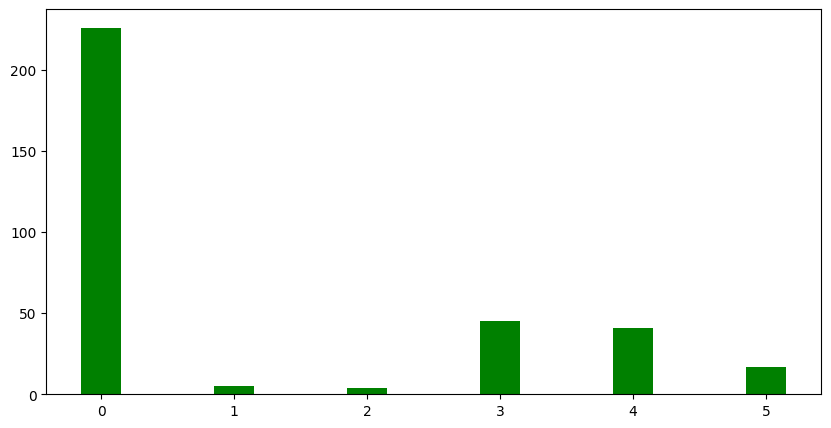

In [311]:
# DISPLAY PREDICTION
test_sample = len(y)


print(y_test[:test_sample])
pred_label = []

preds = model.predict(X_test[:test_sample])

for prediction in preds:
    pred_label.append(np.argmax(prediction))
pred_label = np.array(pred_label)
print('X,y shape: ',X.shape,'/',y.shape,"\nX,y test shape: ",X_test.shape,"/", y_test.shape)
print(pred_label[:test_sample],"\n\n")

evaluate = model.evaluate(X_test[:test_sample],y_test[:test_sample])


unique, counts = np.unique(pred_label, return_counts=True)
unique, ycounts = np.unique(y_test[:test_sample], return_counts=True)


fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(np.arange(6), counts, color ='green', 
        width = 0.3)
plt.bar(np.arange(6), ycounts, color ='blue', 
        width = 0.2,alpha=0.5)
 
plt.xlabel("classes-poses")
plt.ylabel("occurrence")
plt.title("prediction of tuned model")
plt.show()
plt.plot(y_test[:test_sample],color ='green', label="true value")
plt.plot(pred_label,color ='red', linewidth=4, alpha=0.5,label="prediction")
 
plt.xlabel("classes-poses")
plt.ylabel("occurrence")
plt.title("prediction of tuned model")
plt.legend(ncol=1)

plt.show()

## Save a model

In [310]:
# model.save("./models/tuned_model_loss_5.0_0.1_acc_us_15_11.keras")

## load a model

2023-11-25 07:24:57.137692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 07:24:57.138202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 07:24:57.138690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

21/21 [==============================] - 3s 12ms/step


 [0 3 2 3 3 2 0 3 3 2 4 3 3 3 4 2 0 0 3 0 5 1 4 2 3 0 5 0 3 0 0 0 2 5 0 0 5
 0 3 3 5 1 4 1 2 1 5 4 5 1 2 5 4 2 1 1 0 3 5 0 2 5 5 0 0 2 5 2 4 1 1 2 1 4
 0 5 5 3 3 4 3 3 1 5 0 4 4 1 4 2 0 3 4 0 4 2 0 5 1 0 5 3 5 5 0 3 1 0 4 5 4
 5 1 3 4 5 5 1 5 5 2 1 3 3 4 5 5 0 5 2 0 3 1 1 2 5 3 2 3 1 1 3 0 4 4 1 3 2
 4 0 3 2 5 0 5 4 2 2 0 1 4 0 1 1 1 5 1 3 5 2 0 4 5 1 5 3 1 0 3 4 2 1 4 5 4
 3 0 0 2 4 1 2 0 2 5 4 5 2 1 4 3 3 4 3 1 2 3 5 1 4 0 3 2 3 1 3 2 2 2 5 5 4
 0 0 0 0 0 5 2 5 1 0 0 0 0 3 1 2 2 1 1 2 1 2 5 4 1 5 4 0 4 1 5 5 1 0 3 4 1
 2 2 0 2 5 2 5 1 5 2 3 2 1 5 3 5 4 0 5 4 3 4 4 3 1 3 1 4 5 0 0 3 2 5 1 3 5
 3 1 3 3 1 0 5 0 3 2 3 1 0 3 4 5 4 0 5 5 5 0 4 5 2 4 2 3 4 1 0 3 1 0 2 4 2
 1 5 1 4 2 0 0 4 5 4 4 5 4 0 2 0 3 2 2 0 0 5 3 3 4 4 1 3 1 2 5 5 3 1 2 0 5
 3 5 2 2 1 3 2 1 2 5 3 1 5 4 2 2 0 3 1 4 1 4 4 4 3 1 2 3 0 2 2 2 4 2 5 0 0
 2 0 2 4 2 1 5 4 0 2 1 0 3 2 4 2 2 5 3 4 0 4 4 4 3 1 0 4 5 2 0 2 3 3 4 2 1
 0 3 1 5 0 1 2 5 3 4 0 1 4 4 2 5 5 4 0 1 5 

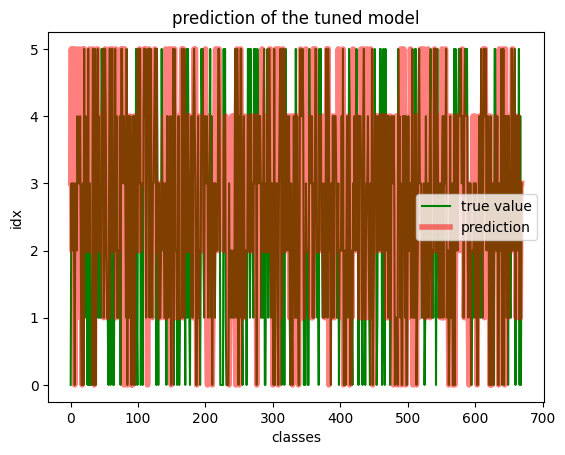

In [4]:
# load_model_1 = keras.models.load_model('./models/tuned_model_loss_2_0.4_acc_new_9_11.keras')
load_model_1 = keras.models.load_model('./models/tuned_model_loss_0.7_0.7_acc_new_10_11.keras')
if(True):
    start_idx = 10
    start_idx = 0
    test_sample = 55
    test_sample = len(X_test)-1
    end_idx = start_idx + test_sample
    preds = load_model_1.predict(X_test[start_idx:end_idx])


    print("\n\n===================================================\n",y_test[start_idx:end_idx])
    pred_label = []
    for prediction in preds:
        pred_label.append(np.argmax(prediction))
    pred_label = np.array(pred_label)
    print("",pred_label[start_idx:end_idx])

    # GRAPH OF OUTPUT OCCURANCE:
    unique, counts = np.unique(pred_label, return_counts=True)
    unique, ycounts = np.unique(y_test, return_counts=True)



    plt.plot(y_test[start_idx:end_idx],color ='green', label="true value")
    plt.plot(pred_label,color ='red', linewidth=4, alpha=0.5,label="prediction")
    
    plt.xlabel("classes")
    plt.ylabel("idx")
    # plt.title("prediction of the best stand-alone model")
    plt.title("prediction of the tuned model")
    plt.legend(ncol=1)

    plt.show()
    # model = new_model



 [2 4 0 4 2 0 0 5 5 4 4 3 0 5 3 1 3 4 0 3 3 1 0 1 1 1 1 1 3 0]
 [2 1]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (6,) and arg 1 with shape (2,).

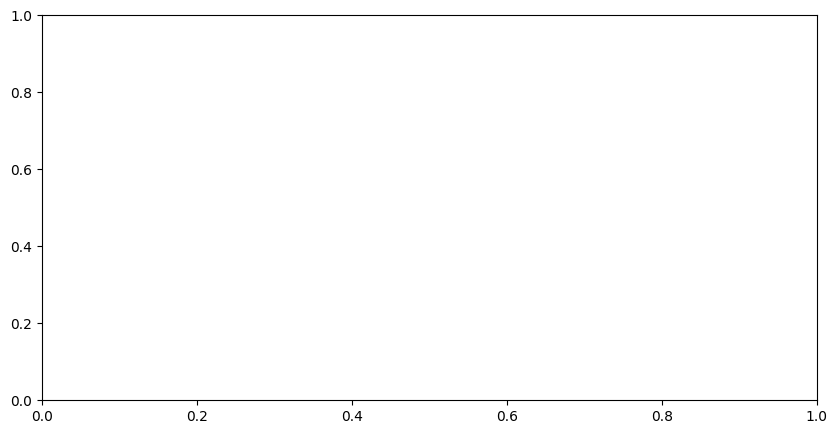

In [42]:
from keras import layers, models, Input, Model, Sequential
load_model = keras.models.load_model('./models/tuned_model_loss_0.7_0.7_acc_new_10_11.keras')
# Show the model architecture
# new_model.summary()

# new_model = Sequential(load_model)
# new_model.add(keras.layers.Lambda(lambda x: K.cast(K.argmax(x), dtype='float32')))
# new_model.add(keras.layers.Dense(1, activation='sigmoid'))

# new_model.compile(optimizer=keras.optimizers.Nadam(
#     learning_rate=1e-3
#      ), loss="sparse_categorical_crossentropy")

# history = new_model.fit(X, y,batch_size=32, epochs=10)
# # new_model.save("./models/test.h5")
# new_model = load_model
new_model = load_model
if(True):

    print("\n\n===================================================\n",y_test[:30])
    pred_label = []
    for prediction in preds:
        pred_label.append(np.argmax(prediction))
    pred_label = np.array(pred_label)
    print("",pred_label[:30])

    # GRAPH OF OUTPUT OCCURANCE:
    unique, counts = np.unique(pred_label, return_counts=True)
    unique, ycounts = np.unique(y_test, return_counts=True)

    fig = plt.figure(figsize = (10, 5))
    
    # creating the bar plot
    plt.bar(np.arange(6), counts, color ='green', 
            width = 0.3)
    plt.bar(np.arange(6), ycounts, color ='blue', 
            width = 0.2,alpha=0.5)
    
    plt.xlabel("classes-poses")
    plt.ylabel("occurrence")
    plt.title("prediction of CNN (not full) model")
    plt.show()
    evaluate = new_model.evaluate(X_test,y_test)

    plt.plot(y_test,color ='green', label="true value")
    plt.plot(pred_label,color ='red', linewidth=4, alpha=0.5,label="prediction")
    
    plt.xlabel("classes-poses")
    plt.ylabel("occurrence")
    plt.title("prediction of tuned model")
    plt.legend(ncol=1)

    plt.show()
    evaluate = new_model.evaluate(X_test,y_test)
    # model = new_model
    from keras.utils import plot_model
    import pydot
    import graphviz
    plot_model(new_model, to_file="./pic/model_0.7_0.7.png", show_shapes=True)

In [ ]:
preds = new_model.predict(X_test)
# np.argmax(prediction)
i = 1
print((preds[i]).astype(float))
# print(np.argmax(preds[i]))

 1/21 [>.............................] - ETA: 0s

21/21 [==============================] - 0s 7ms/step
[3.67361307e-02 4.26251143e-01 5.50138017e-12 5.10832979e-05
 5.36961615e-01 4.34521308e-09]
4


In [ ]:
# new_model = tf.keras.models.load_model('./models/model_0.5_40l_1c_new.keras')
# new_model = tf.keras.models.load_model('./models/model_0.4_40l_1c_new.keras')
# new_model = tf.keras.models.load_model('./models/tuned_model_loss_2_0.4_acc_new_9_11.keras')
new_model = tf.keras.models.load_model('./models/tuned_model_loss_0.7_0.7_acc_new_10_11.keras')
# Show the model architecture
new_model.summary()
pred_label = []

# preds = new_model.predict(X)
# evaluate = new_model.evaluate(X,y)
# print("\n\n===================================================\n",y[:30])


preds = new_model.predict(X_test)
print(evaluate)

print("\n\n===================================================\n",y_test[:30])

for prediction in preds:
    pred_label.append(np.argmax(prediction))
pred_label = np.array(pred_label)
print("",pred_label[:30])

# GRAPH OF OUTPUT OCCURANCE:
unique, counts = np.unique(pred_label, return_counts=True)
unique, ycounts = np.unique(y_test, return_counts=True)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(np.arange(6), counts, color ='green', 
        width = 0.3)
plt.bar(np.arange(6), ycounts, color ='blue', 
        width = 0.2,alpha=0.5)
 
plt.xlabel("classes-poses")
plt.ylabel("occurrence")
plt.title("prediction of CNN (not full) model")
plt.show()
evaluate = new_model.evaluate(X_test,y_test)

plt.plot(y_test,color ='green', label="true value")
plt.plot(pred_label,color ='red', linewidth=4, alpha=0.5,label="prediction")
 
plt.xlabel("classes-poses")
plt.ylabel("occurrence")
plt.title("prediction of tuned model")
plt.legend(ncol=1)

plt.show()
evaluate = new_model.evaluate(X_test,y_test)
# model = new_model
from keras.utils import plot_model
import pydot
import graphviz
plot_model(new_model, to_file="./pic/model_0.7_0.7.png", show_shapes=True)

2023-11-11 09:02:23.915982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 09:02:23.922780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 09:02:23.923352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 40, 40, 1)]       0         
                                                                 
 rescaling_22 (Rescaling)    (None, 40, 40, 1)         0         
                                                                 
 conv2d_38 (Conv2D)          (None, 38, 38, 64)        640       
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 32)        51232     
                                                          

2023-11-11 09:02:25.234403: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-11 09:02:25.783051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-11-11 09:02:26.352299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:188] failed to create cublas handle: the resource allocation failed
2023-11-11 09:02:26.352332: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:191] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-11-11 09:02:26.352928: W tensorflow/core/kernels/conv_ops_gpu.cc:144] None of the algorithm

NotFoundError: Graph execution error:

Detected at node model_21/conv2d_38/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_150197/4209857175.py", line 15, in <module>

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2631, in predict

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/backend.py", line 5397, in relu

No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng11{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(6629): 'status'
  Profiling failure on CUDNN engine eng0{}: UNKNOWN: CUDNN_STATUS_ALLOC_FAILED
in tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc(6629): 'status'
	 [[{{node model_21/conv2d_38/Relu}}]] [Op:__inference_predict_function_535]

# some activation function

In [ ]:
# # some activation functions
# SIGMOID

lim = 50

fig = plt.figure(figsize=(8, 4))
columns = 2
rows = 1

for i in range(1, columns*rows +1):
    x = np.linspace(-lim, lim, 100)
    fig.add_subplot(rows, columns, i)
    if (i==1):
        img = np.random.randint(10, size=(h,w))
        plt.title("S I G M O I D")
        # plt.imshow(X_tl[i-1]*255,cmap='gnuplot2')
        y =1/ (1+math.e **-x)

    else:
        plt.title("R E L U")
        y = []
        for i in x:
            y.append(max(0,i))

    plt.plot(x, y)
    
    
plt.show()
print(y[:(columns*rows)])


# tuning with tuner

In [9]:
def build_model(hp):
    inputs = keras.Input(shape=(w, h, 1))
    x = layers.Rescaling(scale=2)(inputs)

    # Number of layers of the CNN is also a hyperparameter.
    for i in range(hp.Int(f"Conv_1",min_value=1,max_value= 5)):
        x = layers.Conv2D(
            hp.Int(f"filters_{i}", 32, 64, step=5),
            kernel_size=(3, 3),
            activation="relu",
        )(x)
        x = keras.layers.Dropout(0.2)(x,training=True)  

        x = layers.MaxPooling2D(pool_size=(5, 5))(x)
    x = layers.Softmax()(x)
    
    for i in range(hp.Int(f"Denses_1",min_value=1,max_value= 3)):

        x = layers.Dense(
            units=hp.Int(f"units_{i}", 16, 32, step=5), activation="relu",
        )(x)
    x = keras.layers.Dropout(0.2)(x,training=True)  
    # for i in range(hp.Int(f"Conv_2",min_value=1,max_value= 5)):
    #     x = layers.Conv2D(
    #         hp.Int(f"filters_{i}", 32, 64, step=5),
    #         kernel_size=(3, 3),
    #         activation="relu",
    #     )(x)
    x = keras.layers.Dropout(0.2)(x,training=True)  

    # x = layers.MaxPooling2D(pool_size=(5, 5))(x)
    if hp.Boolean("dropout"):
        x = layers.Dropout(0.2)(x)
    for i in range(hp.Int(f"Denses_2",min_value=1,max_value= 3)):
        x = layers.Dense(
            units=hp.Int(f"units_{i}", 32, 128, step=32), activation="relu",
        )(x)
    if hp.Boolean("dropout"):
        x = layers.Dropout(0.5)(x)
    x = layers.Softmax()(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    
    num_classes = 6
    learning_rate = hp.Float(f"lr", min_value=1e-4, max_value=1e-2, sampling="log")
    outputs = layers.Dense(units=num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Nadam(learning_rate=learning_rate), 
            loss="sparse_categorical_crossentropy",
        metrics=['accuracy'])

    return model


hp = keras_tuner.HyperParameters()
hp.values["dropout"] = True
model_tun = build_model(hp)
model_tun(X[:100])
model_tun.summary()

2023-11-16 21:16:11.925052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 40, 40, 1)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 32)        320       
                                                                 
 dropout_2 (Dropout)         (None, 38, 38, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 softmax_1 (Softmax)         (None, 7, 7, 32)          0         
                                                           

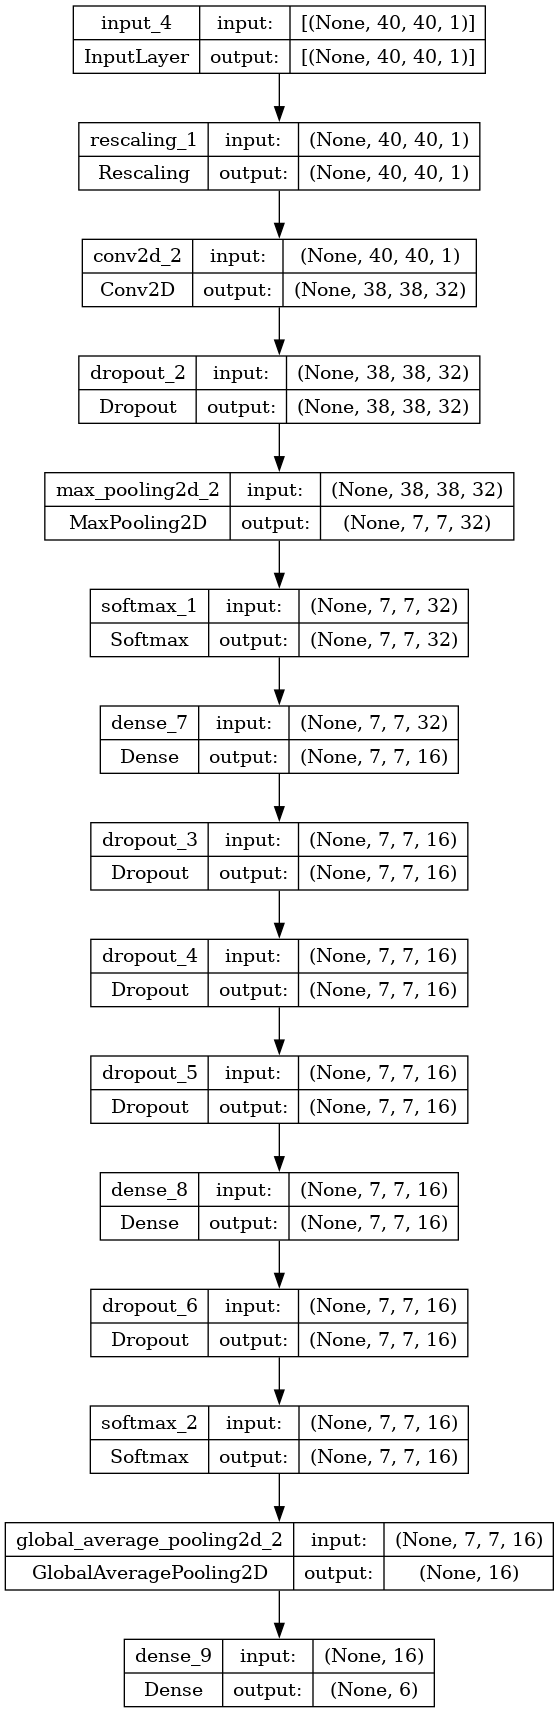

In [10]:
plot_model(model_tun, to_file="/tmp/model.png", show_shapes=True)


In [ ]:
tuner = keras_tuner.tuners.Hyperband(
    build_model,
    objective=['loss','accuracy'],
    max_epochs=2,
    executions_per_trial=2,
    directory='./models/checkpoints/',
    project_name='cyber_arm_tuner',
    )
print("================================================")

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(X, y, epochs=300, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first conv
layer is {best_hps.get('Conv_1')} and the optimal learning rate for the optimizer
is {best_hps.get('lr')}.
""")

# best_model.fit(x=X, y=y, epochs=1)


Reloading Tuner from ./models/checkpoints/cyber_arm_tuner/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first conv
layer is 2 and the optimal learning rate for the optimizer
is 0.00021923887986249234.



In [ ]:
tuner.search_space_summary()

In [ ]:

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(patience=100,monitor='loss'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/checkpoints/model_tuned.{epoch:02d}-{loss:.2f}.h5',
        monitor='loss',
        mode='max',
        save_freq=50,
        save_best_only=True
        ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.0000000000000000001, patience=10)
]
model = tuner.hypermodel.build(best_hps)
model.summary()
history = model.fit(X, y, epochs=30000, validation_split=0.2,callbacks=my_callbacks)

val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 40, 40, 1)         0         
                                                                 
 conv2d_20 (Conv2D)          (None, 38, 38, 37)        370       
                                                                 
 dropout_29 (Dropout)        (None, 38, 38, 37)        0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 7, 7, 37)          0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 5, 5, 32)          10688     
                                                           

2023-11-11 07:53:36.537978: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_29/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 4s 59ms/step - loss: 1.7936 - accuracy: 0.1604 - val_loss: 1.7896 - val_accuracy: 0.1912
Epoch 2/30000
9/9 [==============================] - 0s 30ms/step - loss: 1.7935 - accuracy: 0.1604 - val_loss: 1.7898 - val_accuracy: 0.1912
Epoch 3/30000
9/9 [==============================] - 0s 33ms/step - loss: 1.7935 - accuracy: 0.1604 - val_loss: 1.7899 - val_accuracy: 0.1912
Epoch 4/30000
9/9 [==============================] - 0s 30ms/step - loss: 1.7934 - accuracy: 0.1604 - val_loss: 1.7901 - val_accuracy: 0.1912
Epoch 5/30000
9/9 [==============================] - 0s 29ms/step - loss: 1.7934 - accuracy: 0.1604 - val_loss: 1.7902 - val_accuracy: 0.1912
Epoch 6/30000
9/9 [==============================] - 0s 36ms/step - loss: 1.7933 - accuracy: 0.1604 - val_loss: 1.7903 - val_accuracy: 0.1912
Epoch 7/30000
9/9 [==============================] - 0s 32ms/step - loss: 1.7932 - accuracy: 0.1604 - val_loss: 1.7904 - val_accuracy: 0.1912
Epoch 8/30000
9/9 [=

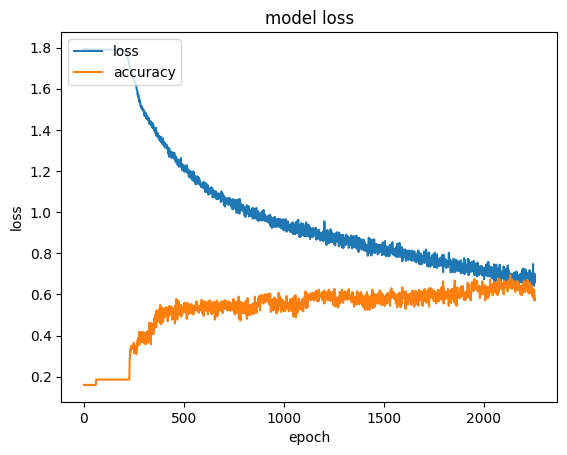

In [ ]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

21/21 [==============================] - 0s 6ms/step


 [5 3 3 0 3 0 4 2 1 3 4 1 3 2 1 4 0 4 5 4 5 5 1 2 0 5 0 3 3 2]
 [5 2 5 2 5 0 4 5 3 2 4 3 5 2 3 4 4 4 5 3 2 2 3 2 1 5 3 2 5 5]


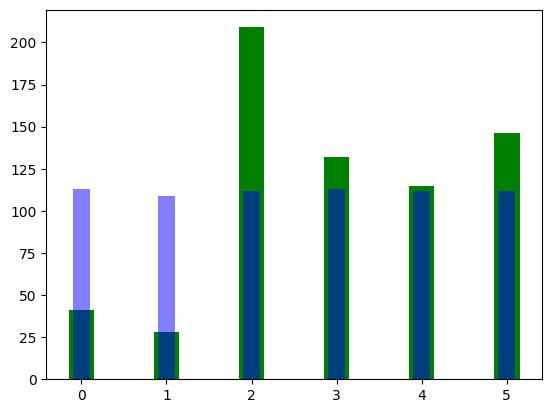

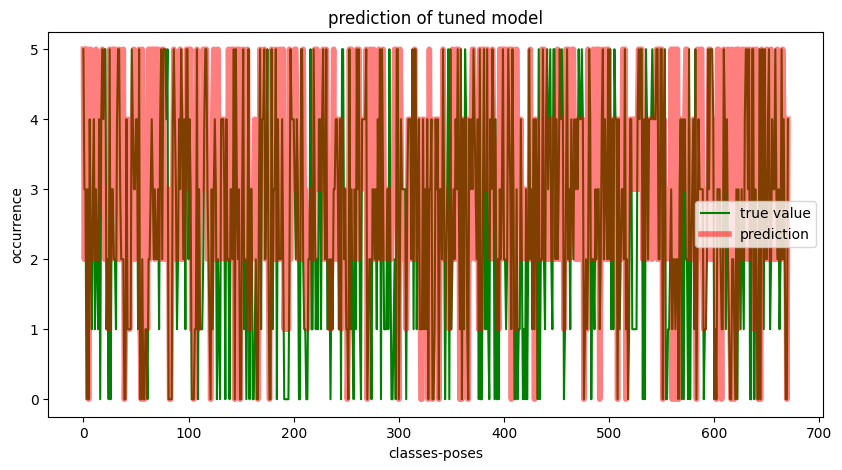

21/21 [==============================] - 0s 6ms/step - loss: 2.3405 - accuracy: 0.3800
[2.340508222579956, 0.3800297975540161]


In [ ]:
preds = model.predict(X_test)
# preds = new_model.predict(X_test)
pred_label=[]
print("\n\n===================================================\n",y_test[:30])

for prediction in preds:
    pred_label.append(np.argmax(prediction))
pred_label = np.array(pred_label)
print("",pred_label[:30])

# GRAPH OF OUTPUT OCCURANCE:
unique, counts = np.unique(pred_label, return_counts=True)
unique, ycounts = np.unique(y_test, return_counts=True)

 
# creating the bar plot
plt.bar(np.arange(6), counts, color ='green', 
        width = 0.3)
plt.bar(np.arange(6), ycounts, color ='blue', 
        width = 0.2,alpha=0.5)
plt.show()
 
fig = plt.figure(figsize = (10, 5))

# PRED GRAPH
plt.plot(y_test,color ='green', label="true value")
plt.plot(pred_label,color ='red', linewidth=4, alpha=0.5,label="prediction")


plt.xlabel("classes-poses")
plt.ylabel("occurrence")
plt.title("prediction of tuned model")
plt.legend(ncol=1)

plt.show()
evaluate = model.evaluate(X_test,y_test)
print(evaluate)


In [ ]:
# model.save("./models/tuned_model_loss_0.3_0.9_acc.keras")

In [ ]:
evaluate = model.evaluate(X_test,y_test)

In [ ]:
new_model = tf.keras.models.load_model('./models/tuned_model_loss_0.2_0.9_acc.keras')
# new_model = tf.keras.models.load_model('./models/model_0.4_40l_1c_new.keras')

# Show the model architecture
new_model.summary()
pred_label = []

# preds = new_model.predict(X)
# evaluate = new_model.evaluate(X,y)
# print("\n\n===================================================\n",y[:30])


preds = new_model.predict(X_test)
print(evaluate)

print("\n\n===================================================\n",y_test[:30])

for prediction in preds:
    pred_label.append(np.argmax(prediction))
pred_label = np.array(pred_label)
print("",pred_label[:30])

# GRAPH OF OUTPUT OCCURANCE:
unique, counts = np.unique(pred_label, return_counts=True)
unique, ycounts = np.unique(y_test, return_counts=True)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(np.arange(6), counts, color ='green', 
        width = 0.3)
plt.bar(np.arange(6), ycounts, color ='blue', 
        width = 0.2,alpha=0.5)
plt.show()

plt.plot(y_test,color ='green', label="true value")
plt.plot(pred_label,color ='red', linewidth=4, alpha=0.5,label="prediction")
 
plt.xlabel("classes-poses")
plt.ylabel("occurrence")
plt.title("prediction of tuned model")
plt.legend(ncol=1)

plt.show()
evaluate = new_model.evaluate(X_test,y_test)





Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 40, 40, 1)]       0         
                                                                 
 rescaling_60 (Rescaling)    (None, 40, 40, 1)         0         
                                                                 
 conv2d_112 (Conv2D)         (None, 38, 38, 64)        640       
                                                                 
 max_pooling2d_138 (MaxPool  (None, 34, 34, 64)        0         
 ing2D)                                                          
                                                                 
 dropout_51 (Dropout)        (None, 34, 34, 64)        0         
                                                                 
 conv2d_113 (Conv2D)         (None, 30, 34, 32)        10272     
                                                          

2023-11-11 11:00:39.118061: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_54/dropout_51/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-11 11:00:39.148280: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:188] failed to create cublas handle: the resource allocation failed
2023-11-11 11:00:39.148303: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:191] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-11-11 11:00:39.148357: W tensorflow/core/kernels/conv_ops_gpu.cc:144] None of the algorithms provided by cuDNN frontend heuristics worked; trying fallback algorithms.  Conv: batch: 32
in_depths: 1
out_depths: 

NotFoundError: Graph execution error:

Detected at node model_54/conv2d_112/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_150197/3263376315.py", line 13, in <module>

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2631, in predict

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/activations.py", line 306, in relu

  File "/media/james/Datasets_Drive1/miniconda/envs/test/lib/python3.11/site-packages/keras/src/backend.py", line 5397, in relu

No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng11{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model_54/conv2d_112/Relu}}]] [Op:__inference_predict_function_52476]

In [ ]:
# model
# new_model
two_nn_dt = tf.reduce_mean(
    tf.stack([model, new_model], axis=0), axis=0)


ValueError: Attempt to convert a value (<keras.src.engine.functional.Functional object at 0x7f7bf486a610>) with an unsupported type (<class 'keras.src.engine.functional.Functional'>) to a Tensor.

# ALGO
## Random Forest

In [ ]:
import math
import urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf


In [ ]:
dataset_train

In [ ]:
print(dataset_test_ar[0][-1])
column_name =np.array(list(range(n*2+1)))
column_name=column_name+1
column_name=column_name.astype('str')
column_name
us = pd.DataFrame(dataset_test_ar,columns=column_name)

5.0


In [ ]:
us

,1,2,3,4,5,6,7,8,9,10,...,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601
0,0.000571,0.000487,0.000905,0.000738,0.000487,0.000571,0.000320,0.000487,0.000738,0.000905,...,0.000367,0.000218,0.000144,0.000293,0.000069,-0.000229,0.000293,0.000740,0.001188,5.0
1,0.000404,0.000404,0.000571,0.000655,0.001073,0.000822,0.000320,0.000655,0.000655,0.000237,...,0.001859,0.004171,0.003798,-0.003959,-0.005077,-0.000155,0.001188,0.004321,0.006633,4.0
2,0.000404,0.000320,0.000487,0.000069,0.000738,0.000905,0.000153,0.000404,0.000320,0.000738,...,0.000144,0.000442,0.000517,0.000740,0.000666,0.000517,0.000591,0.000591,0.000218,5.0
3,-0.000599,-0.000683,-0.000599,-0.000683,-0.000098,0.001156,0.001240,-0.000348,0.000571,0.000404,...,-0.003735,-0.002989,0.001262,0.002605,0.003351,0.003202,0.003724,-0.000155,-0.003213,4.0
4,0.001658,0.000738,-0.000934,0.000822,0.002410,0.001240,-0.000850,0.002995,0.002995,-0.000348,...,0.000367,0.000964,0.003276,0.002381,-0.003362,-0.009627,-0.002467,0.003425,0.005365,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,0.000822,0.000905,0.000404,0.000320,0.000237,0.000822,0.000571,-0.000014,-0.000098,0.000069,...,0.000442,0.000367,0.000218,0.000218,0.000591,0.000591,0.000442,0.000442,0.000591,0.0
667,0.000738,0.000487,0.000655,0.000822,0.000237,0.000404,0.000404,0.000069,-0.000014,0.001240,...,0.001039,0.000964,0.001039,0.000591,0.000442,0.000144,0.000367,0.000144,0.000367,3.0
668,0.000320,0.000320,0.000404,0.000487,0.000655,0.000989,0.000738,0.000069,-0.000014,0.000404,...,0.000666,0.000293,0.000367,0.000293,0.000367,0.000144,0.000442,0.000815,0.000964,5.0
669,0.000655,0.000571,0.000404,0.000069,0.000237,0.000069,0.000237,0.000487,0.000655,0.000738,...,0.000442,0.001113,0.000293,-0.000155,-0.000304,0.000442,0.000293,0.000815,0.001039,5.0


In [ ]:
dataset_train_ar.shape

(337, 1601)

In [ ]:


# Specify the model.
# inputs = tf.keras.layers.Input(shape=(2))
inputs = keras.Input(shape=(img_w_h_len, img_w_h_len, 1))

output = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234,verbose=2)(inputs)

model_1 = tf.keras.models.Model(inputs, output)
model_1.compile(optimizer=tf.keras.optimizers.Nadam(
    learning_rate=1e-3,),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"])

# Train the model.
model_1.fit( X,y,epochs = 1000,validation_split=0.2)

test_sample = 100
evaluate = model_1.evaluate(X_test[:test_sample],y_test[:test_sample])


Use 12 thread(s) for training
Use /tmp/tmpwv8qz6we as temporary training directory


Epoch 1/1000


9/9 [==============================] - 0s 28ms/step - loss: 37.8456 - accuracy: 0.1784 - val_loss: 40.3771 - val_accuracy: 0.1324
Epoch 2/1000
9/9 [==============================] - 0s 8ms/step - loss: 37.8456 - accuracy: 0.1784 - val_loss: 40.3771 - val_accuracy: 0.1324
Epoch 3/1000
9/9 [==============================] - 0s 9ms/step - loss: 37.8456 - accuracy: 0.1784 - val_loss: 40.3771 - val_accuracy: 0.1324
Epoch 4/1000
9/9 [==============================] - 0s 8ms/step - loss: 37.8456 - accuracy: 0.1784 - val_loss: 40.3771 - val_accuracy: 0.1324
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 37.8456 - accuracy: 0.1784 - val_loss: 40.3771 - val_accuracy: 0.1324
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 37.8456 - accuracy: 0.1784 - val_loss: 40.3771 - val_accuracy: 0.1324
Epoch 7/1000
9/9 [==============================] - 0s 8ms/step - loss: 37.8456 - accuracy: 0.1784 - val_loss: 40.3771 - val_accuracy: 0.1324
Epoch 8/1000
9/9 [

In [ ]:
preds = model_1.predict(X_test[:test_sample])
preds

4/4 [==============================] - 0s 2ms/step


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [ ]:
# inputs = keras.Input(shape=(392*2,1))
# input_dim = int(math.sqrt(n*2))
inputs = keras.Input(shape=(img_w_h_len, img_w_h_len, 1))
# inputs = keras.Input(shape=(input_dim,input_dim))

# input_layer = layers.Rescaling(2)(inputs)
input_layer = layers.Rescaling(2)(inputs)


In [ ]:
x = layers.Dense(128, activation="relu")(input_layer)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
num_classes = 6
x = keras.layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

NN_model_1_pred = outputs
NN_model_2_pred = outputs



In [ ]:
Model_rf_1_pred = tfdf.keras.RandomForestModel(num_trees=1000, random_seed=1234,verbose=2)(input_layer)
# Model_rf_1_pred.summary()

Use 12 thread(s) for training
Use /tmp/tmp3kwjoo4s as temporary training directory


In [ ]:
# # Train a Gradient Boosted Trees model.
# model = tfdf.keras.GradientBoostedTreesModel(num_trees=1500)
lbel_index = n*n
train_ds_pred = tfdf.keras.pd_dataframe_to_tf_dataset(us,label=str(n*2+1))

# Specify the model.
# Model_rf_1_pred = tfdf.keras.RandomForestModel(verbose=2).predict(input_layer)
Model_rf_1_pred = tfdf.keras.RandomForestModel(num_trees=100, random_seed=1234,verbose=2)(input_layer)

# # Train the model/
# Model_rf_1 = keras.Model(inputs=inputs, outputs=outputs)
# Model_rf_1.summary()
# Model_rf_1.compile(optimizer=keras.optimizers.Nadam(
#     learning_rate=1e-3
#      ), loss="sparse_categorical_crossentropy")
# Model_rf_1.fit(X,y,batch_size=64, epochs=10)
# Model_rf_1(X_test)

Use 12 thread(s) for training
Use /tmp/tmpv__ltbnf as temporary training directory


In [ ]:
TF_NN = tf.reduce_mean(
    tf.stack([NN_model_1_pred, Model_rf_1_pred], axis=0), axis=0)

# Keras Models
# ============

TF_NN = keras.Model(inputs=inputs, outputs=outputs)

from keras.utils import plot_model

plot_model(TF_NN, to_file="/tmp/model.png", show_shapes=True)

ValueError: Exception encountered when calling layer "tf.stack_5" (type TFOpLambda).

Dimension 1 in both shapes must be equal, but are 6 and 1. Shapes are [?,6] and [?,1].
	From merging shape 0 with other shapes. for '{{node tf.stack_5/stack_1}} = Pack[N=2, T=DT_FLOAT, axis=0](Placeholder, Placeholder_1)' with input shapes: [?,6], [?,1].

Call arguments received by layer "tf.stack_5" (type TFOpLambda):
  • values=['tf.Tensor(shape=(None, 6), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)']
  • axis=0
  • name=stack

In [ ]:
NN_model_1_pred
NN_model_2_pred
TF_NN = tf.reduce_mean(
    tf.stack([NN_model_1_pred, Model_rf_1_pred], axis=0), axis=0)

# Keras Models
# ============

TF_NN = keras.Model(inputs=inputs, outputs=outputs)

from keras.utils import plot_model

plot_model(TF_NN, to_file="/tmp/model.png", show_shapes=True)

# Bluetooth <placeholder>

In [ ]:
import bluetooth

nearby_devices = bluetooth.discover_devices(lookup_names=True)
print("Found {} devices.".format(len(nearby_devices)))

for addr, name in nearby_devices:
    print("  {} - {}".format(addr, name))

# COMBINE


In [6]:
test_sample = 10
test_X_sample_rate = np.array_split(X_test,len(y_test)/(test_sample))
test_y_sample_rate = np.array_split(y_test,len(y_test)/(test_sample))
# np.array(test_X_sample_rate).shape
print(len(test_X_sample_rate))
np.array(test_X_sample_rate[1]).shape
# np.array(test_y_sample_rate)
test_y_sample_rate
tempt_y = []
for ys in test_y_sample_rate:
    tempt_y.append(ys[0])
test_y_sample_rate = tempt_y
test_y_sample_rate = np.array(test_y_sample_rate)
test_y_sample_rate

13


array([0, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5], dtype=uint8)

In [1]:
load_model_1 = keras.models.load_model('./models/tuned_model_loss_0.7_0.7_acc_new_10_11.keras')
load_model_2 = keras.models.load_model('./models/model_0.5_40l_1c_new.keras')
load_model_3 = keras.models.load_model('./models/model_0.4_40l_1c_new.keras')
# load_model_2 = model

NameError: name 'keras' is not defined

In [ ]:
from keras import layers, models, Input, Model, Sequential
start_idx = 114
test_sample = 10 
end_idx= start_idx + test_sample


# Show the model architecture
# new_model.summary()


# history_1 = load_model_1.fit(X, y,batch_size=32, epochs=10)
# history_2 = load_model_2.fit(X, y,batch_size=32, epochs=10)

preds_1 = load_model_1.predict(X_test[start_idx:end_idx])
preds_2 = load_model_2.predict(X_test[start_idx:end_idx])
# preds_3 = load_model_3.predict(X_test[start_idx:end_idx])
# preds = (preds_1 + preds_2 + preds_3)/3
preds = preds_1 + preds_2
y_test[start_idx:end_idx]


1/1 [==============================] - 0s 205ms/step


2023-11-15 17:48:01.158149: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_21/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 0s 245ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [ ]:



pred_c = []
pred_c.append(preds_1)
pred_c.append(preds_2)
pred_c.append(preds_3)
pred_c
preds_label_c = []
for pred in pred_c:
    pred_label = []
    for prediction in preds:
        pred_label.append(np.argmax(prediction))
    pred_label = np.array(pred_label)
    preds_label_c.append(pred_label)
preds_label_c = np.array(preds_label_c)
preds_label_c


array([[4, 1, 4, 4, 1, 0, 4, 4, 1, 1],
       [4, 1, 4, 4, 1, 0, 4, 4, 1, 1],
       [4, 1, 4, 4, 1, 0, 4, 4, 1, 1]])

In [16]:
def max_voting(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num


In [ ]:
ensemble_pred = []
for i in np.arange(test_sample+1):
    i=i-1
    arr = []
    for pred in preds_label_c:
        arr.append(pred[i])
    ensemble_pred.append(max_voting(arr))
ensemble_pred
max_voting(ensemble_pred)


1

In [ ]:
preds[0]

array([3.3907849e-02, 1.6027591e-01, 8.2320190e-10, 6.5885001e-01,
       1.4696623e-01, 1.6406714e-08], dtype=float32)

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 111ms/step


 [5 4 0 3 1 2 0 5 1 4 0 2 4 1 5 5 5 5 1 1 3 3 1 4 3 4 1 0 0 1 2 0 2 4 3 3 4
 5 2 3 1 2 0 5 2 1 1 3 5 0 2 3 2 2 0]
 [3 2 1 4 2 3 5 2 4 4 5 5 1 1 3 4 4 3 3 4 2 0 2 4 3 3 4 2 2 5 4 2 3 2 2 1 4
 2 2 3 2 2 2 2 3]


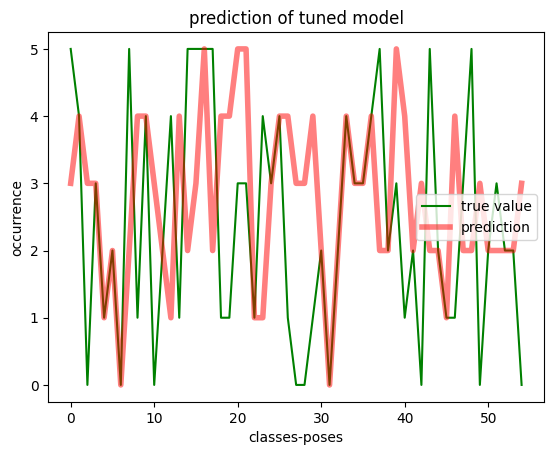

In [302]:
if(True):
    start_idx = 10
    test_sample = 55
    end_idx = start_idx + test_sample
    preds = load_model_1.predict(X_test[start_idx:end_idx])


    print("\n\n===================================================\n",y_test[start_idx:end_idx])
    pred_label = []
    for prediction in preds:
        pred_label.append(np.argmax(prediction))
    pred_label = np.array(pred_label)
    print("",pred_label[start_idx:end_idx])

    # GRAPH OF OUTPUT OCCURANCE:
    unique, counts = np.unique(pred_label, return_counts=True)
    unique, ycounts = np.unique(y_test, return_counts=True)



    plt.plot(y_test[start_idx:end_idx],color ='green', label="true value")
    plt.plot(pred_label,color ='red', linewidth=4, alpha=0.5,label="prediction")
    
    plt.xlabel("classes-poses")
    plt.ylabel("occurrence")
    plt.title("prediction of tuned model")
    plt.legend(ncol=1)

    plt.show()
    # model = new_model


## predict by sample

In [26]:
def max_voting(List):
    counter = 0
    num = List[0]
     
    for i in List:
        curr_frequency = List.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
 
    return num


In [4]:
load_model_1 = keras.models.load_model('./models/tuned_model_loss_0.7_0.7_acc_new_10_11.keras')
load_model_2 = keras.models.load_model('./models/tuned_model_loss_5.0_0.1_acc_us_15_11.keras')
# load_model_3 = model
load_model_3 = keras.models.load_model('./models/tuned_model_loss_2_0.4_acc_new_9_11.keras')
load_model_4 = load_model_1
# load_model_4 = keras.models.load_model('./models/tuned_model_loss_2_0.4_acc_new_9_11.keras')
# load_model_3 = keras.models.load_model('./models/model_0.4_40l_1c_new.keras')

2023-11-25 08:40:06.733825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 08:40:06.739632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 08:40:06.740023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
test_sample = 1

In [22]:
test_X_sample_rate = np.array_split(X_test,len(y_test)/(test_sample))
test_y_sample_rate = np.array_split(y_test,len(y_test)/(test_sample))
print(len(test_X_sample_rate))
np.array(test_X_sample_rate[1]).shape
tempt_y = []
for ys in test_y_sample_rate:
    tempt_y.append(ys[0])
test_y_sample_rate = tempt_y
test_y_sample_rate = np.array(test_y_sample_rate)
test_y_sample_rate



671


array([0, 0, 4, 3, 0, 3, 5, 1, 1, 0, 2, 1, 2, 0, 0, 5, 0, 2, 2, 4, 3, 3,
       1, 3, 2, 2, 3, 0, 2, 4, 3, 4, 5, 0, 0, 4, 4, 1, 5, 3, 5, 2, 4, 2,
       4, 4, 1, 4, 3, 4, 2, 2, 3, 0, 5, 2, 4, 5, 0, 2, 5, 4, 1, 4, 3, 4,
       1, 1, 2, 5, 1, 2, 3, 0, 0, 2, 4, 1, 0, 0, 1, 0, 5, 2, 3, 5, 3, 4,
       0, 3, 5, 4, 5, 4, 1, 5, 1, 1, 0, 2, 0, 1, 2, 0, 0, 3, 5, 1, 4, 5,
       2, 1, 1, 4, 5, 4, 4, 2, 2, 1, 5, 2, 3, 1, 1, 4, 3, 2, 1, 2, 4, 0,
       4, 5, 5, 0, 1, 0, 3, 5, 4, 0, 5, 0, 5, 0, 3, 2, 2, 1, 0, 5, 5, 5,
       5, 1, 3, 0, 1, 4, 4, 0, 1, 3, 4, 3, 0, 4, 4, 4, 4, 1, 2, 5, 3, 3,
       0, 0, 2, 4, 2, 0, 5, 1, 1, 2, 2, 0, 0, 3, 1, 2, 0, 0, 4, 3, 5, 0,
       0, 1, 1, 2, 3, 4, 1, 1, 0, 0, 0, 5, 3, 5, 5, 1, 5, 0, 4, 4, 5, 2,
       2, 2, 0, 3, 4, 2, 0, 5, 1, 4, 2, 4, 4, 2, 4, 2, 2, 2, 1, 0, 4, 0,
       1, 3, 2, 4, 2, 5, 5, 1, 2, 0, 3, 4, 3, 0, 5, 3, 4, 4, 2, 1, 1, 3,
       4, 5, 5, 1, 2, 1, 0, 0, 3, 1, 3, 0, 1, 4, 0, 0, 1, 3, 2, 4, 5, 0,
       3, 2, 0, 3, 4, 3, 4, 3, 4, 5, 3, 1, 2, 1, 3,

In [24]:
lasdfkn = test_X_sample_rate

In [27]:
pred_rate = []
for X_test_rate in test_X_sample_rate:
    preds_1 = load_model_1.predict(X_test_rate)
    preds_2 = load_model_2.predict(X_test_rate)
    preds_3 = load_model_3.predict(X_test_rate)

    pred_c = []
    pred_c.append(preds_1)
    pred_c.append(preds_2)
    pred_c.append(preds_3)
    pred_c = np.array(pred_c)
    pred_c[0]

    t = pred_c[0]

    preds_label_c = []
    for preds in pred_c:
        pred_label = []
        for prediction in preds:
            pred_label.append(np.argmax(prediction))
        pred_label = np.array(pred_label)
        preds_label_c.append(pred_label)
    preds_label_c = np.array(preds_label_c)

    ensemble_pred = []
    for i in np.arange(len(X_test_rate)):
        i=i
        arr = []
        for pred in preds_label_c:
            arr.append(pred[i])
        ensemble_pred.append(max_voting(arr))
    pred_rate.append(max_voting(ensemble_pred))
# max_voting(pred_rate)
pred_rate = np.array(pred_rate)


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

In [15]:
a = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5], dtype='uint8')
b = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 4, 1, 1, 3, 3, 3, 4, 1, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 5,
       5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
       3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 3, 3, 4,
       3, 1, 5, 5, 5, 2, 3, 5, 5, 5, 3, 5, 5, 5, 5, 2, 2, 2, 2, 5, 5, 5,
       3, 5])

matrix1_flat = a.flatten()
matrix2_flat = b.flatten()

similarity_ratio = cosine_similarity([matrix1_flat], [matrix2_flat])[0][0]
print(similarity_ratio)

0.9071463261468489


In [74]:
import difflib

l1 = a
l2 = b

sm = difflib.SequenceMatcher(None,l1,l2)
sm.ratio()


0.6567164179104478

In [28]:
pred_rate

array([3, 3, 4, 3, 0, 3, 2, 4, 4, 4, 2, 4, 2, 1, 3, 3, 3, 2, 2, 1, 3, 3,
       4, 2, 2, 2, 3, 3, 2, 4, 5, 1, 2, 3, 3, 3, 1, 4, 3, 5, 2, 2, 1, 2,
       4, 1, 4, 1, 3, 4, 2, 2, 2, 3, 2, 2, 4, 2, 3, 2, 2, 1, 4, 4, 3, 4,
       1, 4, 2, 2, 4, 2, 5, 3, 3, 2, 4, 1, 3, 3, 4, 3, 5, 2, 3, 2, 3, 4,
       3, 5, 5, 1, 2, 4, 4, 2, 1, 4, 3, 2, 0, 4, 2, 3, 3, 5, 2, 4, 4, 2,
       2, 1, 4, 4, 5, 4, 3, 2, 5, 3, 5, 2, 3, 4, 4, 4, 3, 2, 4, 2, 1, 3,
       4, 5, 2, 0, 1, 3, 2, 3, 3, 3, 5, 1, 5, 3, 5, 2, 2, 4, 0, 5, 2, 3,
       2, 4, 3, 3, 4, 4, 4, 3, 1, 2, 1, 2, 3, 4, 4, 0, 0, 4, 2, 2, 5, 5,
       3, 3, 2, 0, 2, 0, 2, 1, 1, 2, 2, 3, 3, 3, 3, 2, 3, 3, 1, 5, 2, 3,
       3, 4, 4, 2, 1, 4, 1, 4, 3, 3, 3, 5, 3, 5, 2, 4, 2, 3, 4, 0, 2, 2,
       2, 2, 3, 3, 0, 2, 3, 3, 4, 4, 2, 4, 0, 2, 1, 2, 2, 2, 4, 0, 1, 3,
       4, 3, 2, 4, 2, 2, 5, 4, 2, 3, 5, 1, 3, 3, 2, 5, 4, 1, 2, 4, 4, 5,
       1, 5, 5, 4, 2, 4, 3, 0, 3, 4, 3, 3, 4, 4, 3, 0, 1, 3, 2, 4, 2, 3,
       3, 2, 3, 5, 4, 5, 1, 5, 1, 5, 5, 4, 2, 4, 5,



========================= test_y_sample_rate ==========================
 [0 0 4 3 0 3 5 1 1 0 2 1 2 0 0 5 0 2 2 4 3 3 1 3 2 2 3 0 2 4 3 4 5 0 0 4 4
 1 5 3 5 2 4 2 4 4 1 4 3 4 2 2 3 0 5 2 4 5 0 2 5 4 1 4 3 4 1 1 2 5 1 2 3 0
 0 2 4 1 0 0 1 0 5 2 3 5 3 4 0 3 5 4 5 4 1 5 1 1 0 2 0 1 2 0 0 3 5 1 4 5 2
 1 1 4 5 4 4 2 2 1 5 2 3 1 1 4 3 2 1 2 4 0 4 5 5 0 1 0 3 5 4 0 5 0 5 0 3 2
 2 1 0 5 5 5 5 1 3 0 1 4 4 0 1 3 4 3 0 4 4 4 4 1 2 5 3 3 0 0 2 4 2 0 5 1 1
 2 2 0 0 3 1 2 0 0 4 3 5 0 0 1 1 2 3 4 1 1 0 0 0 5 3 5 5 1 5 0 4 4 5 2 2 2
 0 3 4 2 0 5 1 4 2 4 4 2 4 2 2 2 1 0 4 0 1 3 2 4 2 5 5 1 2 0 3 4 3 0 5 3 4
 4 2 1 1 3 4 5 5 1 2 1 0 0 3 1 3 0 1 4 0 0 1 3 2 4 5 0 3 2 0 3 4 3 4 3 4 5
 3 1 2 1 3 5 1 1 3 1 5 3 3 0 5 4 1 3 1 0 2 2 4 4 1 4 5 5 4 3 1 3 1 0 1 4 4
 5 3 4 2 2 2 4 1 5 5 0 3 4 5 3 0 1 5 5 5 5 1 3 3 1 4 5 1 1 2 3 5 5 4 5 0 4
 1 0 4 3 2 2 1 3 3 3 3 4 3 5 4 1 2 3 2 2 0 0 5 4 2 0 2 5 4 4 1 3 2 2 5 5 2
 4 2 1 5 5 2 3 1 5 1 2 0 0 3 2 4 4 2 5 5 1 2 2 4 0 5 0 5 2 2 2 0 5 4 2 3 2
 1 2 2 4 5 3 0 0 0 4 5 5 

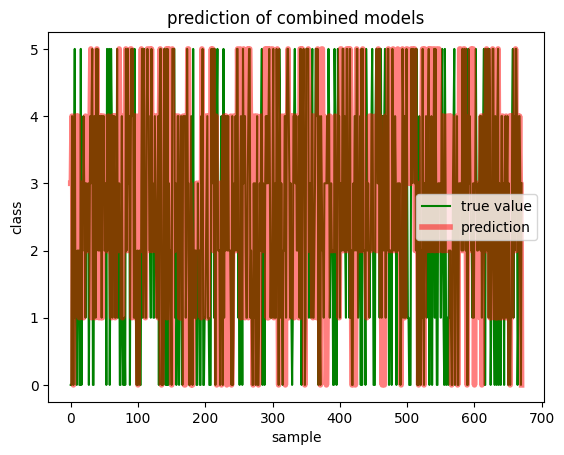

In [33]:
    print("\n\n========================= test_y_sample_rate ==========================\n",test_y_sample_rate)
    print("\n\n====================== pred_rate =============================\n",pred_rate)


    plt.plot(test_y_sample_rate,color ='green', label="true value")
    plt.plot(pred_rate,color ='red', linewidth=4, alpha=0.5,label="prediction")
    
    plt.xlabel("sample")
    plt.ylabel("class")
    plt.title("prediction of combined models")
    plt.legend(ncol=1)

    plt.show()
    # model = new_model

In [31]:
# matrix1_flat = a.flatten()
# matrix2_flat = b.flatten()
matrix1_flat = test_y_sample_rate
matrix2_flat = pred_rate

similarity_ratio = cosine_similarity([matrix1_flat], [matrix2_flat])[0][0]
print(similarity_ratio)

0.7639559750193156


In [32]:
val = str(pred_rate[0])+";"
val

'3;'

In [ ]:
if False:
    import serial
    import time

    arduino = serial.Serial(port='/dev/ttyUSB0',   baudrate=9600, timeout=.1)


    def write_read(x):
        arduino.write(bytes(x,   'utf-8'))
        time.sleep(0.05)
        data = arduino.readline()
        return   data


    # while True:
    idxs = 0
    while idxs <=len(pred_rate):
        # num = input("Enter a number: ")
        val = str(pred_rate[idxs])+";"
        value   = write_read(val)
        # value   = write_read(pred_rate[idxs])
        print(value)


In [1]:
pred_rate =  [0, 0, 3, 3, 2, 2, 3, 3, 3, 4, 3, 5, 5, 0, 1 ,1,1,6, 7,7,0]

In [ ]:
import serial
import time
port="/dev/rfcomm0"
bluetooth = serial.Serial(port=port,   baudrate=9600)
bluetooth.flushInput() 

def write_read(x):
    bluetooth.write(bytes(x,   'utf-8'))
    time.sleep(0.05)
    data = bluetooth.readline()
    return   data


idxs = 0
while idxs <= 5:
    num = input("Enter a number: ") + ";"
    value   = write_read(num)
    print(value)
    idxs+=1
    # print(num)
# bluetooth.close()
# print("Done")

In [3]:
import serial
import time
port="/dev/rfcomm0"
bluetooth = serial.Serial(port=port,   baudrate=9600)
for pred in pred_rate:
    pose  = str(pred) + ";"
    bluetooth.write(bytes(pose,   'utf-8'))
    time.sleep(1.2)
    print(pose)

0;
0;
3;
3;
2;
2;
3;
3;
3;
4;
3;
5;
5;
0;
1;
1;
1;
6;
7;
7;
0;


In [38]:
idxs = 0
while idxs <= 5:
    num = input("Enter a number: ") + ";"
    bluetooth.write(bytes(num,   'utf-8'))
    idxs+=1